# Test Notebook


In [18]:
%load_ext autoreload
%autoreload 2
from lens_simulation import Lens
import matplotlib.pyplot as plt
import numpy as np




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 Lens (width: 0.0005, height: 7e-05, medium: 1.0


 Lens (width: 0.0005, height: 7e-05, medium: 2.0


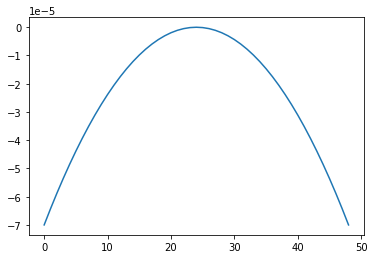

In [38]:
lens = Lens.Lens(
    width=500e-6,
    height=70e-6,
    exponent=2.0
)

print(lens)


profile = lens.generate_profile()
plt.plot(profile)
plt.show()